In [1]:
from IPython.display import display, HTML 
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:15pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:15pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
 """))

In [4]:
import numpy as np
import pandas as pd                                  
import sys
from tensorflow.keras.utils import to_categorical   # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model,load_model # 모델 만들기
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split # 데이터 분리 

### 컬럼명   의미 및 설명

- cp   흉통의 유형 (Chest Pain type)
    - 0: 전형적 협심증 / 1: 비전형적 협심증 / 2: 비심장성 흉통 / 3: 무증상
- treshtbps   안정 시 수축기 혈압 (Resting Blood Pressure in mm Hg)
- chol   혈청 콜레스테롤 수치 (Serum Cholesterol in mg/dl)
- fbs   공복혈당 120mg/dl 이상 여부 (Fasting Blood Sugar) - 1: Yes, 0: No
- restecg   안정 시 심전도 결과 (Resting Electrocardiographic Results)
    - 0: 정상 / 1: ST-T 이상 / 2: 좌심실 비대 가능성
- thalach   최대 심박수 (Maximum Heart Rate Achieved)
- exang   운동 중 협심증 여부 (Exercise Induced Angina) - 1: 있음, 0: 없음
- oldpeak   운동 후 ST 감소 정도 (ST Depression induced by exercise relative to rest)
- slope   ST segment의 기울기 (Slope of the peak exercise ST segment)
    - 1: 수평  / 2: 상승  / 3: 하강
- ca   형광투시검사에서 관찰된 주요 혈관 수 (Number of major vessels colored by fluoroscopy)
- hsl (일반적으로 thal로 표기됨)   지혈소 상태 (Thalassemia)
    - 3: 정상 / 6: 고정결함 / 7: 가역적 결함
- heartDisease   심장병 여부 (Target Variable)
    - 1: 심장병 있음 / 0: 없음

# 이진분류

```
1. 데이터 셋 생성 & 전처리 
    엑셀 -> 데이터 프레임 -> ? 처리(df.replace('?',np.nan) -> 결측치 처리 
    -> x,y 분리 -> X변수 스케일 조정 - > train_test_split함수로 학습셋과 테스트셋 분리(2개로 분리)
    
2. 모델 생성(입력 13, 출력1) & 학습과정 설정 & 학습
3. 모델 평가 (그래프, 평가, 교차표) ※회귀분석에는 교차표 못 그림 
4 모델 사용 (저장,예측) 0.5보다 큰지
```


# 분류분석

```
1. 데이터 셋 생성 & 전처리 
    엑셀 -> 데이터 프레임 -> ? 처리(df.replace('?',np.nan) -> 결측치 처리 
    -> x,y 분리 -> X변수 스케일 조정 - > train_test_split함수로 학습셋과 테스트셋 분리(2개로 분리)
    -> y변수들의 원핫인코딩
    
2. 모델 생성(입력 13, 출력2) & 학습과정 설정 & 학습
3. 모델 평가 (그래프, 평가, 교차표)
4 모델 사용 (저장,예측) argmax
```

# 이진분류
## 1. 데이터 셋 생성 & 전처리 
    엑셀 -> 데이터 프레임 -> ? 처리(df.replace('?',np.nan) -> 결측치 처리 
    -> x,y 분리 -> X변수 스케일 조정 - > train_test_split함수로 학습셋과 테스트셋 분리(2개로 분리)


In [99]:
# 데이터 셋 생성 
dataset = pd.read_excel('data/heart-disease.xlsx')
dataset.info() # ?(물음표)가있다면 int가 안나오고 object로 나타남

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [100]:
dataset.isin(['?']).any() # 물음표가 있는 열 여부

age             False
sex             False
cp              False
treshtbps       False
chol             True
fbs             False
restecg         False
thalach         False
exang           False
oldpeak         False
slope           False
ca               True
hsl              True
heartDisease    False
dtype: bool

In [35]:
dataset # 결측치 있는 원본 데이터

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7,1
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7,1
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


In [101]:
dataset[(dataset['chol']=='?')|(dataset['ca']=='?')|(dataset['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [45]:
# 결측치 처리
new_dataset = dataset.replace('?',np.nan)
(new_dataset =='?').sum().sum()
# (dataset == '?').sum().sum()
new_dataset # ?를 nan으로 바꾼 데이터

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [89]:
last_dataset = new_dataset.fillna(new_dataset.median(numeric_only=True))
(last_dataset == '?').sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [137]:
# target변수의 분포(0:음성, 1:양성)
print(last_dataset['heartDisease'].value_counts())
# negative, positive = last_dataset['heartDisease'].value_counts()
# total = last_dataset.shape[0]
# print('음성 결과 :', negative/total)
# print('양성 결과 :', positive/total)
print(last_dataset['heartDisease'].value_counts(normalize=True))

0    164
1    139
Name: heartDisease, dtype: int64
0    0.541254
1    0.458746
Name: heartDisease, dtype: float64


In [191]:
#X,y 데이터 분리
# train_test_split함수를 써야하기에 2차원으로 해야 함
X_data = last_dataset.iloc[:,:-1].values  
X_data
y_data = last_dataset.iloc[:,-1:].values
y_data
X_data.shape, y_data.shape

((303, 13), (303, 1))

In [ ]:
# X 데이터 스케일 조정

In [193]:
# X 데이터 스케일 조정
# scaler는 데이터프레임을 위한것? 
scaler_x = MinMaxScaler() 
scaled_x_data = scaler_x.fit_transform(X_data)
scaled_x_data
scaler_x.transform([[0,63,1,1,145,233.0,1,2,150,0,2.3,3,6.0]])

array([[-6.04166667e-01,  6.30000000e+01,  0.00000000e+00,
        -8.77358491e-01,  4.33789954e-02,  2.33000000e+02,
         5.00000000e-01, -5.26717557e-01,  1.50000000e+02,
         0.00000000e+00,  6.50000000e-01,  1.00000000e+00,
         7.50000000e-01]])

In [194]:
# 음성|양성 비율
print(pd.DataFrame(y_data).value_counts(normalize=True))
print(pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))

0    0.541254
1    0.458746
dtype: float64
heartDisease
0               0.542453
1               0.457547
dtype: float64
heartDisease
0               0.538462
1               0.461538
dtype: float64


In [195]:
# 층화추출(stratify)로 데이터셋 7:3으로 분활
# train_test_split 함수 사용 하여 학습데이터, 테스트 데이터 분리 

X_train, X_test, y_train, y_test = train_test_split(
 X_data,y_data,
 test_size=0.3,
 random_state=7,
 stratify=y_data) # 층화추출
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((212, 13), (91, 13), (212, 1), (91, 1))

## 2. 모델 생성(입력 13, 출력1) & 학습과정 설정 & 학습

In [196]:
#모델 구성
model = Sequential() # 모델 객체 생성
model.add(Input(shape=(13,)))
model.add(Dense(units=39, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()
# 13*39+39=546/ 39*52+52=2080/52*13+13=689/13*1+1=14

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 39)                546       
                                                                 
 dense_52 (Dense)            (None, 64)                2560      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 16)                1040      
                                                                 
 dense_54 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,163
Trainable params: 4,163
Non-trainable params: 0
_________________________________________________________________


In [197]:
# 모델 학습과정 설정
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['binary_accuracy',     # 정확도
                        metrics.Recall(),     # 재현율(실제값중심)
                        metrics.Precision()]) # 정밀도

In [198]:
# 모델 학습
hist = model.fit(X_train, y_train,
                 epochs=100,
                 batch_size=30,
                 validation_split=0.2,
                 verbose=1)

Epoch 1/100
6/6 [==============================] - 1s 46ms/step - loss: 3.5741 - binary_accuracy: 0.5680 - recall_2: 0.4211 - precision_2: 0.5246 - val_loss: 4.1875 - val_binary_accuracy: 0.4884 - val_recall_2: 1.0000 - val_precision_2: 0.4884
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 2.4272 - binary_accuracy: 0.4970 - recall_2: 0.4342 - precision_2: 0.4400 - val_loss: 0.6698 - val_binary_accuracy: 0.5581 - val_recall_2: 0.0952 - val_precision_2: 1.0000
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 1.0202 - binary_accuracy: 0.5562 - recall_2: 0.6447 - precision_2: 0.5052 - val_loss: 0.6486 - val_binary_accuracy: 0.6047 - val_recall_2: 0.2857 - val_precision_2: 0.7500
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 0.8467 - binary_accuracy: 0.6095 - recall_2: 0.3553 - precision_2: 0.6136 - val_loss: 0.6037 - val_binary_accuracy: 0.6047 - val_recall_2: 0.9524 - val_precision_2: 0.5556
Epoch 5/100
6/6 [=========

6/6 [==============================] - 0s 9ms/step - loss: 0.5111 - binary_accuracy: 0.7396 - recall_2: 0.7763 - precision_2: 0.6860 - val_loss: 0.5255 - val_binary_accuracy: 0.7907 - val_recall_2: 0.7619 - val_precision_2: 0.8000
Epoch 35/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4863 - binary_accuracy: 0.7574 - recall_2: 0.5526 - precision_2: 0.8571 - val_loss: 0.5632 - val_binary_accuracy: 0.7209 - val_recall_2: 0.8571 - val_precision_2: 0.6667
Epoch 36/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4971 - binary_accuracy: 0.7278 - recall_2: 0.6579 - precision_2: 0.7143 - val_loss: 0.5184 - val_binary_accuracy: 0.8140 - val_recall_2: 0.7619 - val_precision_2: 0.8421
Epoch 37/100
6/6 [==============================] - 0s 10ms/step - loss: 0.4910 - binary_accuracy: 0.7515 - recall_2: 0.7368 - precision_2: 0.7179 - val_loss: 0.5015 - val_binary_accuracy: 0.8605 - val_recall_2: 0.8571 - val_precision_2: 0.8571
Epoch 38/100
6/6 [================

Epoch 68/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3737 - binary_accuracy: 0.8166 - recall_2: 0.7500 - precision_2: 0.8261 - val_loss: 0.4517 - val_binary_accuracy: 0.8605 - val_recall_2: 0.8571 - val_precision_2: 0.8571
Epoch 69/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3826 - binary_accuracy: 0.8225 - recall_2: 0.7632 - precision_2: 0.8286 - val_loss: 0.5162 - val_binary_accuracy: 0.7907 - val_recall_2: 0.8571 - val_precision_2: 0.7500
Epoch 70/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3829 - binary_accuracy: 0.8166 - recall_2: 0.7105 - precision_2: 0.8571 - val_loss: 0.4618 - val_binary_accuracy: 0.8372 - val_recall_2: 0.8571 - val_precision_2: 0.8182
Epoch 71/100
6/6 [==============================] - 0s 8ms/step - loss: 0.3899 - binary_accuracy: 0.8284 - recall_2: 0.8158 - precision_2: 0.8052 - val_loss: 0.4354 - val_binary_accuracy: 0.8140 - val_recall_2: 0.7619 - val_precision_2: 0.8421
Epoch 72/100
6/6 [======

In [199]:
# 모델 평가 
hist.history.keys()

dict_keys(['loss', 'binary_accuracy', 'recall_2', 'precision_2', 'val_loss', 'val_binary_accuracy', 'val_recall_2', 'val_precision_2'])

In [200]:
print(np.isnan(X_train).sum().sum())
# print(np.isnan(y_train).sum().sum())


0


In [201]:
y_test[:5]

array([[1],
       [1],
       [0],
       [1],
       [1]], dtype=int64)

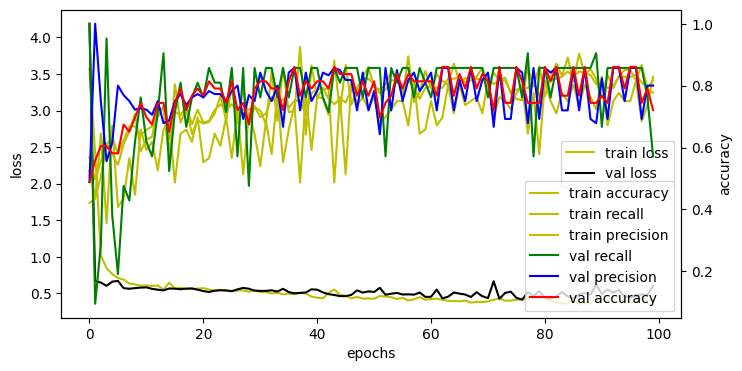

In [203]:
fig, loss_ax = plt.subplots(figsize=(8,4))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'k', label='val loss')
acc_ax = loss_ax.twinx() #loss_ax의 x축 공유
acc_ax.plot(hist.history['binary_accuracy'], 'y', label='train accuracy')
acc_ax.plot(hist.history['recall_2'], 'y', label='train recall')
acc_ax.plot(hist.history['precision_2'], 'y', label='train precision')
acc_ax.plot(hist.history['val_recall_2'], 'g', label='val recall')
acc_ax.plot(hist.history['val_precision_2'], 'b', label='val precision')
acc_ax.plot(hist.history['val_binary_accuracy'], 'r', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend() # bbox_to_anchor=(0.82712,0.76)

In [204]:
score = model.evaluate(X_test,y_test, verbose=0)
print('loss :',score[0])
print('model accuracy :',score[1])
print('model recall :',score[2])
print('model precision :',score[3])

loss : 0.4118582010269165
model accuracy : 0.791208803653717
model recall : 0.6190476417541504
model precision : 0.8965517282485962


In [205]:
# 교차표 
y_test.reshape(-1)


array([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0], dtype=int64)

In [207]:

y_hat = (model.predict(X_test)>0.5).astype(int).reshape(-1)
pd.crosstab(y_test.reshape(-1), y_hat, 
           rownames=['실제값'], colnames=['예측값'])

3/3 [==============================] - 0s 2ms/step


예측값,0,1
실제값,,
0,46,3
1,16,26


# 4. 모델 사용(저장,예측)

In [208]:
model.save('model/07heaer.h5')
save_model(model,'model/07heaer.h5')

In [209]:
model2 = load_model('model/07heaer.h5')

# 분류분석


```
1. 데이터 셋 생성 & 전처리 
    엑셀 -> 데이터 프레임 -> ? 처리(df.replace('?',np.nan) -> 결측치 처리 
    -> x,y 분리 -> X변수 스케일 조정 - > train_test_split함수로 학습셋과 테스트셋 분리(2개로 분리)
    -> y변수들의 원핫인코딩
    
2. 모델 생성(입력 13, 출력2) & 학습과정 설정 & 학습
3. 모델 평가 (그래프, 평가, 교차표)
4 모델 사용 (저장,예측) argmax
```

## 1. 데이터셋 생성 & 전처리 

In [215]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((212, 2), (91, 2))

## 2. 모델 생성(입력13, 출력2) & 학습과정 설정 & 학습

In [216]:
#모델 구성
model = Sequential() # 모델 객체 생성
model.add(Input(shape=(13,)))
model.add(Dense(units=39, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=16, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))
model.summary()
# 13*39+39=546

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 39)                546       
                                                                 
 dense_56 (Dense)            (None, 64)                2560      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 16)                1040      
                                                                 
 dense_58 (Dense)            (None, 2)                 34        
                                                                 
Total params: 4,180
Trainable params: 4,180
Non-trainable params: 0
_________________________________________________________________


In [223]:
# 모델 학습과정 설정
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy',     # 정확도
                        metrics.Recall(),     # 재현율(실제값중심)
                        metrics.Precision()]) # 정밀도

In [224]:
# 모델 학습
hist = model.fit(X_train, Y_train, # 훈련데이터
                epochs=200,
                validation_split=0.2, # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0)

In [226]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_5', 'precision_5', 'val_loss', 'val_accuracy', 'val_recall_5', 'val_precision_5'])

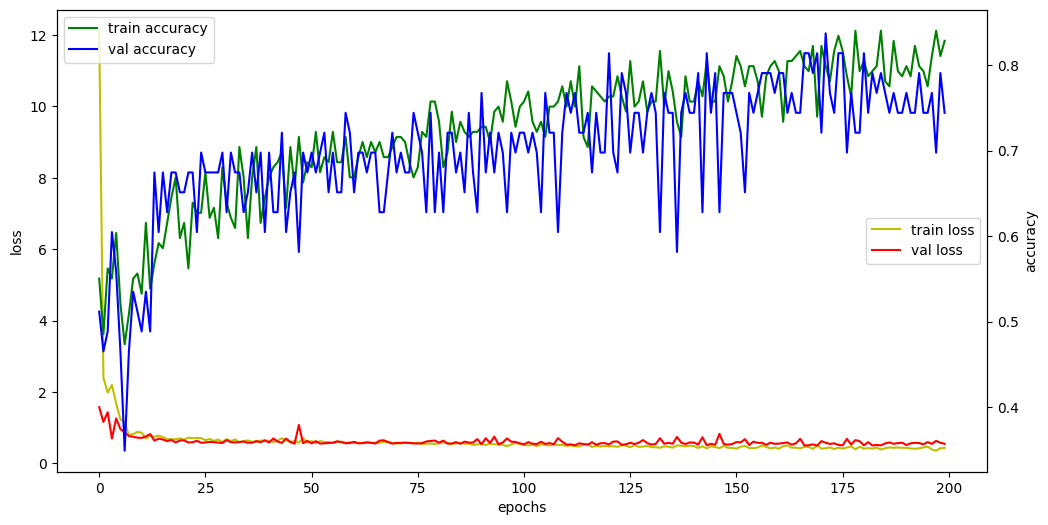

In [227]:

fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend()
plt.show()

In [228]:

score = model.evaluate(X_test, Y_test, verbose=0)
print('model loss : ', score[0])
print('model accuracy : ', score[1])
print('model recall : ', score[2])
print('model precision : ', score[3])

model loss :  0.44382211565971375
model accuracy :  0.7802197933197021
model recall :  0.7802197933197021
model precision :  0.7802197933197021


In [229]:

# 교차표
y_hat = model.predict(X_test).argmax(axis=1)
y_hat

3/3 [==============================] - 0s 2ms/step


array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0], dtype=int64)

In [230]:

pd.crosstab(y_test.reshape(-1), y_hat,
           rownames=['실제값'],
           colnames=['예측값'])

예측값,0,1
실제값,,
0,49,0
1,20,22
